# Connecting

In [7]:
import os
import numpy as np

# setting working dir
os.chdir("../src")

In [77]:
from elasticsearch_db.elasticsearch import elastic_conection
from elasticsearch_db.elasticsearch import get_nlp_model

es = elastic_conection()

In [78]:
workspace_id = "dc1e7b3d-9137-4a20-a99c-d0d2029ef170"
workspace, exist = get_nlp_model(es, workspace_id=workspace_id)
exist

True

# Data Sourcing

In [79]:
from data_pipeline.data_sourcing import get_data

#get_data?

In [80]:
df = get_data(workspace=workspace, es=es)
df.head()

,intents,examples
0,Incluir_Colaborador_Convenio,Acabei de entrar na empresa eu ja tenho plano ...
1,Incluir_Colaborador_Convenio,eu ainda nao recebi o carteirinha do plano de ...
2,Incluir_Colaborador_Convenio,"Fui admitido a pouco tempo, em quanto tempo po..."
3,Incluir_Colaborador_Convenio,"Fui admitido recentemente, quando poderei util..."
4,Incluir_Colaborador_Convenio,Gostaria de saber se meu dependentes foi inclu...


# Data Preprocessing

### Create artificial Examples

In [6]:
# from data_pipeline.data_preprocessing import fill_missing_examples

# fill_missing_examples?

In [7]:
# data = fill_missing_examples(data)

### Cleansing

In [81]:
from data_pipeline.data_preprocessing import clean_examples

#clean_examples?

In [82]:
df = clean_examples(df)

In [83]:
df.head()

,intents,examples,cleaned_examples
0,Incluir_Colaborador_Convenio,Acabei de entrar na empresa eu ja tenho plano ...,acab entr empr ja plan saud
1,Incluir_Colaborador_Convenio,eu ainda nao recebi o carteirinha do plano de ...,aind nao receb carte plan saud
2,Incluir_Colaborador_Convenio,"Fui admitido a pouco tempo, em quanto tempo po...",fui admit pouc temp quant temp pod utiliz plan...
3,Incluir_Colaborador_Convenio,"Fui admitido recentemente, quando poderei util...",fui admit recent pod utiliz plan saud odont
4,Incluir_Colaborador_Convenio,Gostaria de saber se meu dependentes foi inclu...,gost sab depend inclu plan saud odontolog


# Feature Extracting

In [84]:
from data_pipeline.feature_extracting import encode_features

df, x_transformer, y_transformer = encode_features(df)
df.head(2)

,intents,examples,cleaned_examples,intents_onehot,13o,1a,2808sem,2k,2o,abaix,...,vou,vr,vtnc,word,workflow,wwwpremiertravelc,xau,yar,yarin,zacarin
0,Incluir_Colaborador_Convenio,Acabei de entrar na empresa eu ja tenho plano ...,acab entr empr ja plan saud,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Incluir_Colaborador_Convenio,eu ainda nao recebi o carteirinha do plano de ...,aind nao receb carte plan saud,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Data Splitting

In [85]:
from data_pipeline.data_splitting import split

In [86]:
X_train, X_test, y_train, y_test = split(df)

In [12]:
X_train.shape

(817, 1174)

In [13]:
X_test.shape

(403, 1174)

In [14]:
y_train.shape

(817, 2)

In [15]:
y_test.shape

(403, 2)

In [16]:
y_test.head()

,intents,intents_onehot
152,Detalhe_Sobre_Desconto,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1164,Transferir_Colaborador_Filial,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
887,Direito_ao_13,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
821,Verificar_Historico_Previdencia,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1017,Hora_Extra,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [17]:
y_test.intents.nunique()

190

In [18]:
y_train.intents.nunique()

190

# Training

#### Logistic Regression

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import numpy as np

def train_logreg(X, y, **hyper_parameters):
    model = LogisticRegression(
                    n_jobs=-1,
                    **hyper_parameters
            )
        

    model.fit(X, y.intents)
    return model

In [39]:
hyper_parameters = {
                "multi_class": "multinomial",
                "fit_intercept": False,
                "C": 5,
                "random_state": 42,
                "max_iter": 1000}

logreg_clf = train_logreg(
                    X=X_train, 
                    y=y_train,
                    **hyper_parameters
            )

In [24]:
y_pred = logreg_clf.predict(X_test)
np.sum(y_pred == y_test.intents) / y_test.shape[0]

0.5558312655086849

In [25]:
logreg_clf.predict_proba([X_test.iloc[0]])

array([[0.00382202, 0.00376217, 0.00387697, 0.00434802, 0.00378701,
        0.0203652 , 0.00386112, 0.00377277, 0.00379206, 0.00383809,
        0.00382853, 0.00379151, 0.00388488, 0.00384033, 0.00376115,
        0.00519271, 0.00386738, 0.0038066 , 0.00366764, 0.00382163,
        0.00381047, 0.00376541, 0.00382149, 0.00379371, 0.00385451,
        0.00375297, 0.00385807, 0.00486169, 0.00384127, 0.00386689,
        0.00383927, 0.00382324, 0.00381353, 0.00383143, 0.00340203,
        0.00379665, 0.00382706, 0.00382519, 0.00997034, 0.00378374,
        0.00379642, 0.00371985, 0.00440795, 0.00376949, 0.00379666,
        0.0052829 , 0.00379539, 0.00383139, 0.00385898, 0.00380309,
        0.010825  , 0.00381768, 0.0038315 , 0.00375465, 0.00495597,
        0.00386907, 0.00383727, 0.00380407, 0.00388131, 0.00385049,
        0.00567158, 0.00382539, 0.00421234, 0.00384935, 0.00381869,
        0.00799066, 0.00988192, 0.00647337, 0.04390462, 0.00383904,
        0.00386376, 0.00383673, 0.00386777, 0.00

#### SVM

In [2]:
from sklearn import svm

def train_svm(X, y, **hyper_parameters):
    model = svm.SVC(
                    probability=True,
                    **hyper_parameters
              )
        
    model.fit(X, y.intents)
    return model

In [27]:
hyper_parameters = {
          "kernel": "poly", 
          "degree": 1,
          "coef0": 0,
          "random_state": 42
        }
svm_clf = train_svm(
                X=X_train, 
                y=y_train,
                **hyper_parameters
            )

In [28]:
y_pred = svm_clf.predict(X_test)
np.sum((y_pred == y_test.intents)) / y_test.shape[0]

0.4838709677419355

In [29]:
svm_clf.predict_proba([X_test.iloc[0]])

array([[0.00306106, 0.00641751, 0.00408806, 0.00452781, 0.00490817,
        0.00694625, 0.0021326 , 0.0023639 , 0.00467333, 0.00193648,
        0.00478029, 0.00496637, 0.00296317, 0.00322381, 0.00436512,
        0.01044907, 0.00268255, 0.00603941, 0.00993999, 0.00222272,
        0.00314836, 0.00394817, 0.0055226 , 0.00359113, 0.00241712,
        0.00401117, 0.00192506, 0.00458564, 0.00408386, 0.00290265,
        0.00210494, 0.00492424, 0.00450757, 0.00299924, 0.00204994,
        0.00425702, 0.00679804, 0.00206433, 0.01587772, 0.00464743,
        0.00492184, 0.00543427, 0.0031828 , 0.00294165, 0.00319342,
        0.01034369, 0.0048632 , 0.00204229, 0.00405178, 0.00316612,
        0.00836922, 0.00354562, 0.00245942, 0.00593224, 0.00348146,
        0.00248887, 0.00316653, 0.00433585, 0.00334471, 0.00264401,
        0.00331257, 0.00271333, 0.00857719, 0.00543311, 0.00447885,
        0.013201  , 0.00522042, 0.00940554, 0.0219233 , 0.00422381,
        0.00459447, 0.00260931, 0.00251267, 0.00

#### Neural Network

In [37]:
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [5]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.compose import TransformedTargetRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
import pandas as pd



# Keras Model
def build_nn(learning_rate, loss, 
            number_of_intent_classes,
            n_features,
            input_shape):
    
    model = Sequential()
    model.add(
            Dense(
                units=input_shape[0],
                activation="relu",
                input_shape=input_shape,
                name="input_layer",
            )
    )
    model.add(Dense(units=input_shape[0], activation="relu", name="layer_2"))
    # Output
    model.add(
        Dense(units=number_of_intent_classes, activation="softmax", name="output_layer")
    )

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=loss,
        metrics=["accuracy"]
    )
    return model


def train_nn(X, y, **hyper_parameters):
    learning_rate = 0.001
    loss = "categorical_crossentropy"
    number_of_intent_classes = X.intents.nunique()
    n_features = X.shape[1]
    input_shape = (n_features,)
    model = build_nn(learning_rate, loss, 
                     number_of_intent_classes,
                     n_features,
                     input_shape)
    X = X.to_numpy()
    y = np.array(y.intents_onehot.tolist())
    history = model.fit(
                    X,
                    y,
                    **hyper_parameters
              )
    
    return model, history

In [35]:
import pandas as pd

hyper_parameters = {
  "epochs": 100,
  "verbose":True,
  "batch_size": 200,
  "validation_data": (X_test.to_numpy(), np.array(y_test.intents_onehot.tolist()))
}


nn_clf, history = train_nn(
                X=X_train, 
                y=y_train,
                **hyper_parameters
          )

Epoch 1/100
5/5 [==============================] - 1s 154ms/step - loss: 5.2406 - accuracy: 0.0235 - val_loss: 5.1889 - val_accuracy: 0.0521
Epoch 2/100
5/5 [==============================] - 0s 73ms/step - loss: 5.1156 - accuracy: 0.1656 - val_loss: 5.0919 - val_accuracy: 0.0571
Epoch 3/100
5/5 [==============================] - 0s 65ms/step - loss: 4.9341 - accuracy: 0.1322 - val_loss: 4.9599 - val_accuracy: 0.0447
Epoch 4/100
5/5 [==============================] - 0s 64ms/step - loss: 4.7168 - accuracy: 0.1022 - val_loss: 4.8501 - val_accuracy: 0.0397
Epoch 5/100
5/5 [==============================] - 0s 97ms/step - loss: 4.4787 - accuracy: 0.1115 - val_loss: 4.6957 - val_accuracy: 0.0844
Epoch 6/100
5/5 [==============================] - 0s 91ms/step - loss: 4.1973 - accuracy: 0.2682 - val_loss: 4.4960 - val_accuracy: 0.1911
Epoch 7/100
5/5 [==============================] - 1s 111ms/step - loss: 3.8624 - accuracy: 0.4288 - val_loss: 4.2608 - val_accuracy: 0.1960
Epoch 8/100
5/5 [=

Epoch 59/100
5/5 [==============================] - 1s 117ms/step - loss: 0.0206 - accuracy: 0.9944 - val_loss: 1.8401 - val_accuracy: 0.5385
Epoch 60/100
5/5 [==============================] - 0s 104ms/step - loss: 0.0136 - accuracy: 0.9969 - val_loss: 1.8601 - val_accuracy: 0.5335
Epoch 61/100
5/5 [==============================] - 1s 130ms/step - loss: 0.0141 - accuracy: 0.9969 - val_loss: 1.8666 - val_accuracy: 0.5335
Epoch 62/100
5/5 [==============================] - 1s 144ms/step - loss: 0.0131 - accuracy: 0.9957 - val_loss: 1.8746 - val_accuracy: 0.5285
Epoch 63/100
5/5 [==============================] - 1s 190ms/step - loss: 0.0144 - accuracy: 0.9961 - val_loss: 1.8776 - val_accuracy: 0.5285
Epoch 64/100
5/5 [==============================] - 1s 172ms/step - loss: 0.0123 - accuracy: 0.9957 - val_loss: 1.8605 - val_accuracy: 0.5310
Epoch 65/100
5/5 [==============================] - 1s 214ms/step - loss: 0.0114 - accuracy: 0.9957 - val_loss: 1.8730 - val_accuracy: 0.5385
Epoch 

In [36]:
y_pred = nn_clf.predict_classes(X_test.to_numpy());
y_test_argmax = np.array([np.argmax(v) for v in y_test.intents_onehot.tolist()])
np.sum((y_pred == y_test_argmax)) / y_test.shape[0]

/usr/local/lib/python3.6/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.5210918114143921

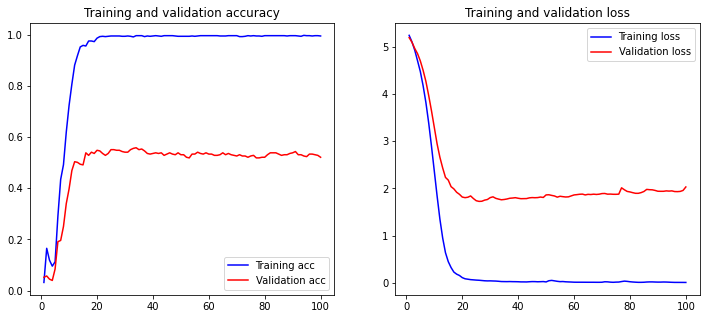

In [38]:
plot_history(history)

# Train pipeline

In [8]:
from data_pipeline.data_preprocessing import clean

class EnsembleModel:
    def __init__(self, x_transformer, y_transformer, models=[]):
        self.x_transformer = x_transformer
        self.y_transformer = y_transformer
        self.models = models
        
    def transform_input(self, sentence):
        sentence = clean(sentence)
        return self.x_transformer.transform([sentence])
        
    def predict(self, sentence):
        vector = self.transform_input(sentence)
        vector = vector.toarray()
        pred = 0
        sum_acc = 0
        for model in self.models:
            sum_acc += model["acc"]
            if model["type"] != "nn":
                pred += model["model"].predict_proba(vector) * model["acc"]
            else:
                pred += model["model"].predict(vector) * model["acc"]
        return pred / sum_acc
    
        

In [9]:
def accuracy(model, X_test, y_test, nn=False):
    if not nn:
        y_pred = model.predict(X_test)
        return np.sum((y_pred == y_test.intents)) / y_test.shape[0]
    else:
        y_pred = model.predict_classes(X_test.to_numpy());
        y_test_argmax = np.array([np.argmax(v) for v in y_test.intents_onehot.tolist()])
        nn_acc = np.sum((y_pred == y_test_argmax)) / y_test.shape[0]
        return nn_acc

def train_models(X_train, y_train, X_test, y_test):
    models = []
    svm_hyper_parameters = {
          "kernel": "poly", 
          "degree": 1,
          "coef0": 0,
          "random_state": 42
        }
    logreg_hyper_parameters = {
                "multi_class": "multinomial",
                "fit_intercept": False,
                "C": 5,
                "random_state": 42,
                "max_iter": 1000}
    
    nn_parameters = {
      "epochs": 100,
      "verbose":False,
      "batch_size": 200,
      "validation_data": (X_test.to_numpy(), np.array(y_test.intents_onehot.tolist()))
    }

    logreg_clf = train_logreg(
                    X=X_train, 
                    y=y_train,
                    **logreg_hyper_parameters
                )
    logreg_acc = accuracy(logreg_clf, X_test, y_test)
    models.append({"model": logreg_clf,
                   "type": "logreg",
                   "acc": logreg_acc,
                   "hyper_parameters": logreg_hyper_parameters})
    
    svm_clf = train_svm(
                    X=X_train, 
                    y=y_train,
                    **svm_hyper_parameters
                )
    svm_acc = accuracy(svm_clf, X_test, y_test)
    models.append({"model": svm_clf,
                   "type": "svm",
                   "acc": svm_acc,
                   "hyper_parameters": svm_hyper_parameters})
 
    nn_clf, history = train_nn(
                    X=X_train, 
                    y=y_train,
                    **nn_parameters
              )
    nn_acc = accuracy(nn_clf, X_test, y_test, nn=True)
    models.append({"model": nn_clf,
                   "type": "nn",
                   "acc": nn_acc,
                   "hyper_parameters": nn_parameters})
    
    return models
    
    

In [10]:
models = train_models(X_train, y_train, X_test, y_test)

NameError: name 'X_train' is not defined

In [92]:
ensemble = EnsembleModel(x_transformer, y_transformer, models)

In [89]:
sentence = "quero adiantar meu 13º"

In [93]:
ensemble.predict(sentence)

array([[0.00286435, 0.00352983, 0.00273201, 0.00273833, 0.00304177,
        0.00331954, 0.00212338, 0.00375717, 0.01406485, 0.18343378,
        0.00526122, 0.00410387, 0.0024497 , 0.00248836, 0.00282622,
        0.00392242, 0.00231839, 0.00350949, 0.00918173, 0.00215154,
        0.00246486, 0.00863698, 0.00320888, 0.00299193, 0.00220595,
        0.00275046, 0.00200682, 0.00570197, 0.0027013 , 0.00238169,
        0.00212216, 0.00303504, 0.00290867, 0.00236846, 0.0020853 ,
        0.00277708, 0.00366545, 0.00210542, 0.00481116, 0.002942  ,
        0.00380532, 0.00324048, 0.00232877, 0.00238079, 0.00246991,
        0.00470308, 0.00296681, 0.00209511, 0.00275142, 0.00245143,
        0.00337355, 0.00263786, 0.00218536, 0.00356414, 0.00235487,
        0.00220942, 0.00246989, 0.00280542, 0.00249975, 0.00227635,
        0.00249584, 0.00236229, 0.00390367, 0.00320319, 0.00437282,
        0.00420293, 0.00361153, 0.03933776, 0.00293288, 0.00275829,
        0.00291953, 0.00352622, 0.00248737, 0.00

# Prefect

In [11]:
import os

# setting working dir
os.chdir("../src")

from prefect import Flow, task, context
import numpy as np

from data_pipeline.data_sourcing import get_data
from data_pipeline.data_preprocessing import fill_missing_examples, clean_examples
from data_pipeline.feature_extracting import encode_features
from data_pipeline.data_splitting import split
from elasticsearch_db.elasticsearch import elastic_conection
from elasticsearch_db.elasticsearch import get_nlp_model

es = elastic_conection()
workspace_id = "dc1e7b3d-9137-4a20-a99c-d0d2029ef170"
workspace, exist = get_nlp_model(es, workspace_id=workspace_id)
exist

True

In [14]:
@task
def sourcing(workspace, es):
    
    return get_data(
                workspace=workspace, 
                es=es
            )

# @task
# def imputation(df):
    
#     return fill_missing_examples(df)

@task
def cleansing(df):

    return clean_examples(df)

@task(nout=3)
def encoding(df):
    
    return encode_features(df)

@task(nout=4)
def splitting(df):

    return split(df)

@task
def training(X_train, y_train, X_test, y_test, x_transformer, y_transformer):
    models = train_models(X_train, y_train, X_test, y_test)
    ensemble = EnsembleModel(x_transformer, y_transformer, models)
    return ensemble

@task
def save_model(ensemble):
    pass


In [15]:
# Define prefect flow
with Flow("train_dataflow") as flow:

    df = sourcing(workspace=workspace, es=es)
    df = cleansing(df=df)
    df, x_transformer, y_transformer = encoding(df=df)
    X_train, X_test, y_train, y_test = splitting(df=df)
    ensemble = training(X_train, y_train, X_test, y_test, x_transformer, y_transformer)
    save_model(ensemble)

[2021-05-22 16:33:16+0000] INFO - prefect.FlowRunner | Beginning Flow run for 'train_dataflow'
[2021-05-22 16:33:16+0000] INFO - prefect.TaskRunner | Task 'sourcing': Starting task run...
[2021-05-22 16:33:16+0000] INFO - prefect.TaskRunner | Task 'sourcing': Finished task run for task with final state: 'Success'
[2021-05-22 16:33:17+0000] INFO - prefect.TaskRunner | Task 'cleansing': Starting task run...
[2021-05-22 16:33:18+0000] INFO - prefect.TaskRunner | Task 'cleansing': Finished task run for task with final state: 'Success'
[2021-05-22 16:33:18+0000] INFO - prefect.TaskRunner | Task 'encoding': Starting task run...
[2021-05-22 16:33:18+0000] INFO - prefect.TaskRunner | Task 'encoding': Finished task run for task with final state: 'Success'
[2021-05-22 16:33:18+0000] INFO - prefect.TaskRunner | Task 'encoding[1]': Starting task run...
[2021-05-22 16:33:18+0000] INFO - prefect.TaskRunner | Task 'encoding[1]': Finished task run for task with final state: 'Success'
[2021-05-22 16:33

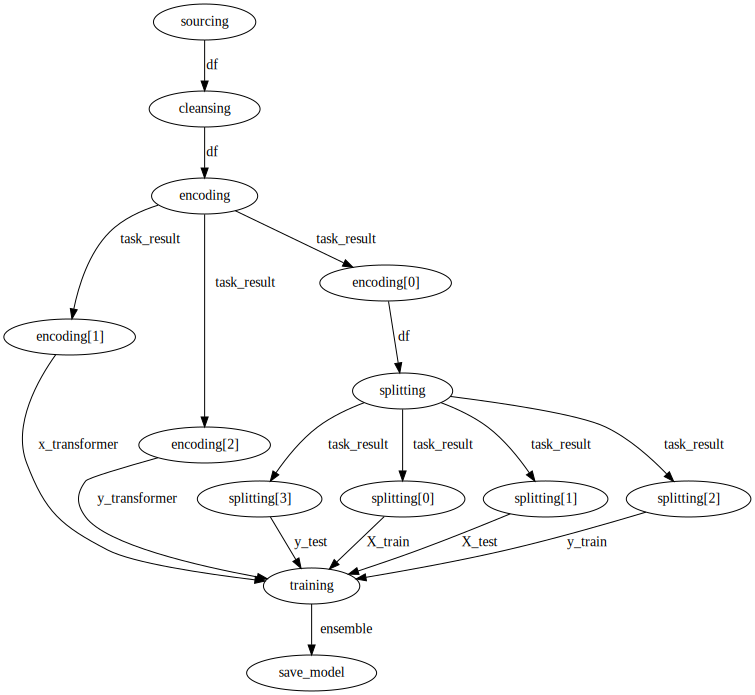

In [16]:
# Run prefect flow
flow.run()

# Export flow as a PDF
flow.visualize(filename="../src/data_pipeline/flow_diagrams/train_dataflow")